In [15]:
import ipywidgets as widgets
from HARK.ConsumptionSaving.ConsPortfolioModel import SequentialPortfolioConsumerType
from HARK.utilities import plot_funcs

import math
import matplotlib.pyplot as plt
import numpy as np

In [16]:
at = SequentialPortfolioConsumerType(PermGroFac=[1.0])
at.track_vars += ["aNrm", "cNrm", "mNrm", "Risky", "Share", "aLvl", "pLvl"]
at.solve()

cFunc = at.solution[0].cFuncAdj
ShareFunc = at.solution[0].ShareFuncAdj

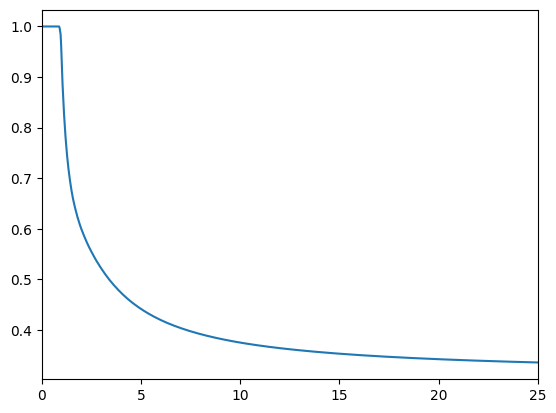

In [17]:
plot_funcs(ShareFunc, 0, 25)

In [18]:
dividend_growth_rate = 1.000203
dividend_std = 0.011983


def price_dividend_ratio_random_walk(DiscFac, CRRA, days_per_quarter=90):
    # Assuming DiscFac in argument in quarterly
    DiscFac_daily = DiscFac ** (1.0 / days_per_quarter)

    dividend_shock_std = dividend_std / math.sqrt(dividend_growth_rate)

    subjective_return = (
        dividend_growth_rate ** (1 - CRRA)
        * DiscFac_daily
        * (dividend_shock_std**2 + 1) ** (CRRA * (CRRA - 1) / 2)
    )

    print("subjective_return: " + str(subjective_return))
    return subjective_return < 1

In [19]:
def portfolio_choice(CRRA=6.0, DiscFac=0.9, RiskyAvg=1.08, RiskyStd=0.20):
    agent_parameters = {}

    agent_parameters["CRRA"] = CRRA

    agent_parameters["DiscFac"] = DiscFac

    agent_parameters["RiskyAvg"] = RiskyAvg

    agent_parameters["RiskyStd"] = RiskyStd

    print("Solving...")

    agent = SequentialPortfolioConsumerType(**agent_parameters)

    agent.solve()

    print("Solved!")

    srle1 = price_dividend_ratio_random_walk(DiscFac, CRRA)

    print("subjective_return < 1?: " + str(srle1))

    plot_funcs(agent.solution[0].ShareFuncAdj, 0, 5)

    plot_funcs(agent.solution[0].cFuncAdj, 0, 5)

    cFunc = agent.solution[0].cFuncAdj

    ShareFunc = agent.solution[0].ShareFuncAdj

    def expected_increase(mNrm):
        share = ShareFunc(mNrm)

        aNrm = mNrm - cFunc(mNrm)

        mNrm_next = (
            aNrm
            * (
                share * agent.parameters["RiskyAvg"]
                + (1 - share) * agent.parameters["Rfree"]
            )
            + 1
        )

        gain = mNrm_next - aNrm

        return gain

    def expected_m_next(mNrm):
        share = ShareFunc(mNrm)

        aNrm = mNrm - cFunc(mNrm)

        mNrm_next = (
            aNrm
            * (
                share * agent.parameters["RiskyAvg"]
                + (1 - share) * agent.parameters["Rfree"]
            )
            + 1
        )

        return mNrm_next

    mNrm = np.linspace(0, 5, 1000)

    # plt.plot(mNrm, cFunc(mNrm), label="c")

    plt.plot(mNrm, mNrm - expected_m_next(mNrm), label="m - E[m']")

    plt.plot(mNrm, np.zeros_like(mNrm), label="0")

    # plt.plot(mNrm, (mNrm - cFunc(mNrm)) * ShareFunc(mNrm), label ="wealth-into-market" )

    plt.legend()

In [20]:
widgets.interact(
    portfolio_choice,
    CRRA=(2, 10, 1),
    DiscFac=(0.5, 0.99, 0.02),
    RiskyAvg=(1.0, 1.1, 0.01),
    RiskyStd=(0.01, 0.3, 0.05),
    continuous_update=False,
)

interactive(children=(IntSlider(value=6, description='CRRA', max=10, min=2), FloatSlider(value=0.9, descriptio…

<function __main__.portfolio_choice(CRRA=6.0, DiscFac=0.9, RiskyAvg=1.08, RiskyStd=0.2)>

Questions:

- How can we compute the `E[aNrm[t-1]]` values from a given `mNrm[t]`, such that we can go from the consumption/expected gain intercept to an equilibrium normalized asset value?
- What we need for the SHARKFin economy to be at equilibrium is for the consumers to have a finite equilibium _level_ of assets (not normalized by labor income). How to do we compute it when permanent labor income is following a random walk?


Answers:

- We can instead compute the `mNrm - E[mNrm']` to determine savings and dissavings regions. This exercise shows the target wealth occurs in the region where the agent is investing all savings in the market. Does target wealth occur in the region where the agent has a non-trivial risky share under some parametrization?
